# Final Project : Facial Feature Localization

### CSC 215-01 Artificial Intelligence (Fall 2019)

### Team member : 
    1) Ayushi Vadwala
    2) Jeet Shah

### Problem Formulation :   
    The aim of the project is to find the facial features on the gray scale images given as input. The output of the model will be the predicted value of the facial coordinates in (x, y) format which will help in placing the facial filter on the image.
            
### Models used to predict Facial Feature Locations : 
- Convolutional Neural Network (CNN)
- Applying Facial Filter with the help of predicted facial feature locations.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df_train = pd.read_csv('data/training.csv')
df_test = pd.read_csv('data/test.csv')

In [14]:
def string2image(string):
    """Converts a string to a numpy array."""
    return np.array([int(item) for item in string.split()]).reshape((96, 96))

def plot_faces(nrows=6, ncols=6):
    """Randomly displays some faces from the training data."""
    selection = np.random.choice(df_train.index, size=(nrows*ncols), replace=False)
    image_strings = df_train.loc[selection]['Image']
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for string, ax in zip(image_strings, axes.ravel()):
        ax.imshow(string2image(string), cmap='gray')
        ax.axis('off')
        
def plot_faces_with_keypoints(nrows=6, ncols=6):
    """Randomly displays some faces from the training data with their keypoints."""
    selection = np.random.choice(df_train.index, size=(nrows*ncols), replace=False)
    image_strings = df_train.loc[selection]['Image']
    keypoint_cols = list(df_train.columns)[:-1]
    keypoints = df_train.loc[selection][keypoint_cols]
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for string, (iloc, keypoint), ax in zip(image_strings, keypoints.iterrows(), axes.ravel()):
        xy = keypoint.values.reshape((15, 2))
        ax.imshow(string2image(string), cmap='gray')
        ax.plot(xy[:, 0], xy[:, 1], 'b*')
        ax.axis('off')
        
def plot_m(ax, center_xy, dx):
    """Plots a moustache scaled by its width, dx, on current ax."""
    moustache_scaled = moustache_contour.copy()
    moustache_scaled -= moustache_contour.min(axis=0)
    moustache_scaled /= moustache_scaled.max(axis=0)[1]
    deltas = moustache_scaled.max(axis=0) - moustache_scaled.min(axis=0)
    moustache_scaled -= np.array([deltas[0]/2, deltas[1]/2])
    moustache_scaled *= dx
    moustache_scaled += center_xy[::-1]
    ax.fill(moustache_scaled[:, 1], moustache_scaled[:, 0], "k", linewidth=4)

def plot_s(ax, center_xy, dx):
    """Plots a moustache scaled by its width, dx, on current ax."""
    star_scaled = star_contour.copy()
    star_scaled -= star_contour.min(axis=0)
    star_scaled /= star_scaled.max(axis=0)[1]
    deltas = star_scaled.max(axis=0) - star_scaled.min(axis=0)
    star_scaled -= np.array([deltas[0]/2, deltas[1]/2])
    star_scaled *= dx
    star_scaled += center_xy[::-1]
    ax.fill(star_scaled[:, 1], star_scaled[:, 0], "r", linewidth=4)
    
def moustache(predicted_points, ax):
    """Draws a moustache using the predicted face points."""
    dx = 2 * np.linalg.norm(predicted_points[12, :] - predicted_points[11, :])
    center_xy = predicted_points[13, :]
    plot_m(ax, center_xy, dx)
    
def star(predicted_points, ax):
    """Draws a moustache using the predicted face points."""
    dx = 2 * np.linalg.norm(predicted_points[9, :] - predicted_points[8, :])
    center_xy = predicted_points[1, :]
    plot_s(ax, center_xy, dx)
    
def plot_faces_with_filter(model, nrows=5, ncols=5, model_input='flat'):
    """Plots sampled faces with their truth and predictions."""
    selection = np.random.choice(np.arange(X_test.shape[0]), size=(nrows*ncols), replace=False)
    fig, axes = plt.subplots(figsize=(10, 10), nrows=nrows, ncols=ncols)
    for ind, ax in zip(selection, axes.ravel()):
        img = X_test[ind, :, :, 0]
        if model_input == 'flat':
            predictions = model.predict(img.reshape(1, -1))
        else:
            predictions = model.predict(img[np.newaxis, :, :, np.newaxis])
        xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)
        ax.imshow(img, cmap='gray')
        moustache(xy_predictions, ax)
        star(xy_predictions, ax)
        ax.axis('off')

In [5]:
df_train.T[:5]

,0,1,2,3,4,5,6,7,8,9,...,7039,7040,7041,7042,7043,7044,7045,7046,7047,7048
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253,69.6807,64.1319,67.4689,65.8029,64.1212,...,69.2299,63.353,65.7112,67.9293,66.8672,67.4025,66.1344,66.6907,70.9651,66.9383
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213,39.9687,34.29,39.4135,34.7552,36.7403,...,38.5756,35.6713,38.8435,35.8466,37.3569,31.8426,38.3655,36.8452,39.8537,43.4245
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448,29.1836,29.579,29.356,27.4758,29.4689,...,29.4079,33.9521,32.2688,28.6878,30.7509,29.7467,30.4786,31.6664,30.5433,31.0961
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042,37.5634,33.138,39.6217,36.1856,38.3902,...,38.3455,40.8164,37.706,41.4525,40.1157,38.6329,39.9502,39.685,40.7723,39.5286
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659,62.8643,57.7972,59.555,58.6522,58.6209,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_test[:5]

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


#### In training dataset images are given as pixels. So, we have converted that pixels into images using defination plot_faces().

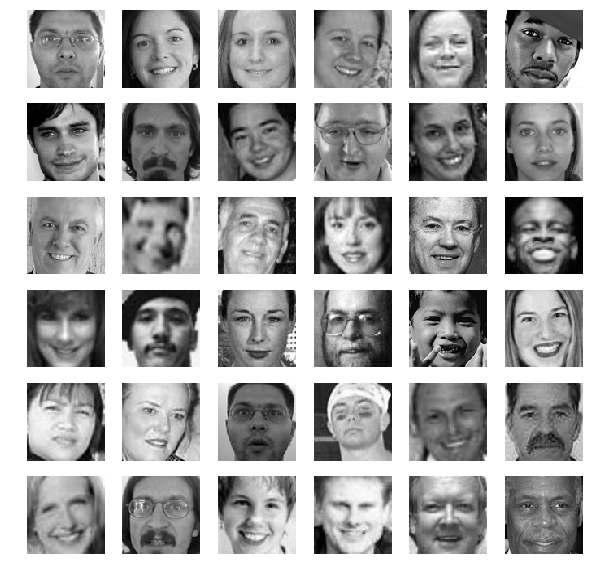

In [15]:
plot_faces()

#### Storing keypoints given in training dataset into a list.

In [16]:
keypoint_cols = list(df_train.columns)[:-1]

In [17]:
locations = df_train.iloc[0][keypoint_cols].values.reshape((15, 2))
locations

array([[66.0335639098, 39.0022736842],
       [30.2270075188, 36.4216781955],
       [59.582075188000005, 39.647422556399995],
       [73.1303458647, 39.9699969925],
       [36.3565714286, 37.3894015038],
       [23.4528721805, 37.3894015038],
       [56.9532631579, 29.0336481203],
       [80.2271278195, 32.2281383459],
       [40.2276090226, 29.0023218045],
       [16.3563789474, 29.6474706767],
       [44.4205714286, 57.0668030075],
       [61.1953082707, 79.9701654135],
       [28.6144962406, 77.38899248119999],
       [43.3126015038, 72.9354586466],
       [43.1307067669, 84.4857744361]], dtype=object)

#### Plotting face images with their related keypoints.

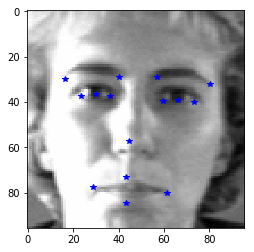

In [18]:
plt.plot(locations[:, 0], locations[:, 1], 'b*')
plt.imshow(string2image(df_train.iloc[78]['Image']), cmap='gray')

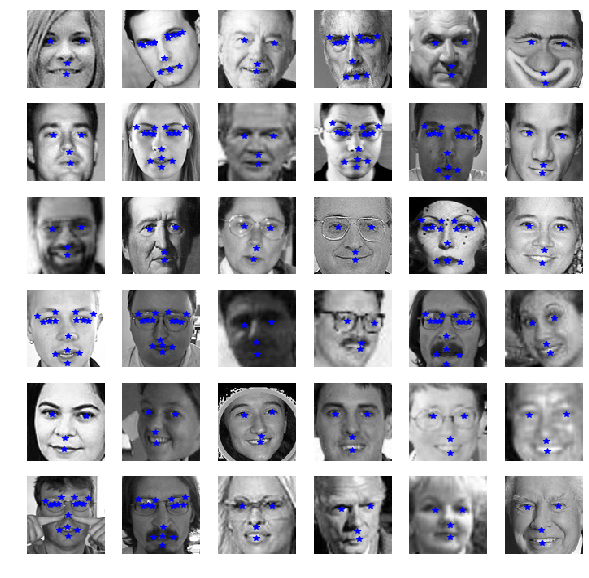

In [19]:
plot_faces_with_keypoints()

In [20]:
df_train.shape

(7049, 31)

In [21]:
df_test.shape

(1783, 2)

#### Detecting OUTLIERS in Dataset
- The statistics about the key point from below BAR graph suggests that this dataset, only 2140 images are "high quality" with all keypoints, while 4909 other images are "low quality" with only 4 keypoints labelled which are the outliers.

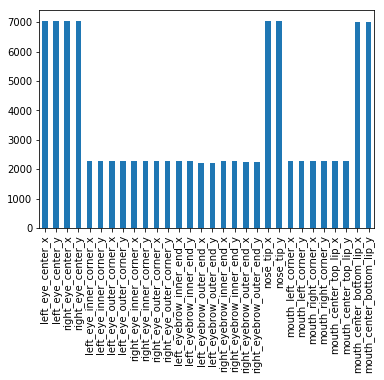

In [22]:
df_train.describe().loc['count'].plot.bar()

In [23]:
df_train = df_train.dropna()

In [24]:
df_train.shape

(2140, 31)

#### After removing outliers every images have all 30 keypoints.

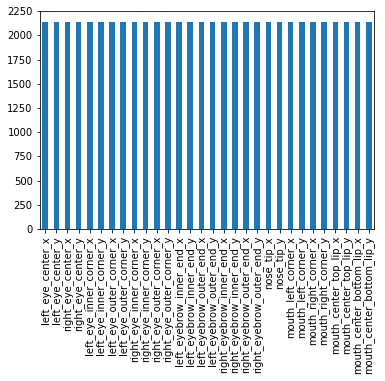

In [25]:
df_train.describe().loc['count'].plot.bar()

#### Since CNN works with the 4-d array, We have to reshape all images into 4-d array.

In [11]:
image_list=[]

for i in df_train['Image']:
    i=i.split(' ')
    image_list.append(i)
len(image_list)

2140

In [12]:
#convert to array
image_list = np.array(object=image_list,dtype=float)

In [13]:
images = image_list.reshape(-1,96,96,1)

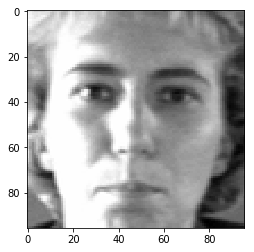

In [14]:
plt.imshow(image_list.reshape(-1,96,96)[78],cmap='gray')

In [15]:
y = df_train.drop(labels='Image',axis=1)
y.shape

(2140, 30)

In [16]:
x = images
x.shape

(2140, 96, 96, 1)

In [17]:
x= np.asarray(x)
y= np.asarray(y)

#### Spliting training dataset into train and test using sklearn's train_test_split method.

In [18]:
from sklearn.model_selection import train_test_split

global random_seed
random_seed = 9
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_seed)

In [19]:
X_train.shape

(1712, 96, 96, 1)

In [20]:
y_train.shape

(1712, 30)

In [21]:
X_test.shape

(428, 96, 96, 1)

In [22]:
y_test.shape

(428, 30)

#### Train basic CNN model by adding different layers into model.

In [23]:
import tensorflow as tf
model= tf.keras.models.Sequential(
    
    layers=[
        
         #convolution 1st time
        tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),activation=tf.nn.relu,input_shape=(96,96,1)),
        tf.keras.layers.MaxPool2D(2,2),
     
         #convolution 2nd time
        tf.keras.layers.Conv2D(filters=64,kernel_size=(2,2),activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(2,2),
       
         #convolution 2nd time
        tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(2,2),
        
         #convolution 2nd time
        tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),activation=tf.nn.relu),
        tf.keras.layers.MaxPool2D(2,2),
      
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=500,activation='relu'),
        tf.keras.layers.Dropout(0.3),
        

        # number of keypoint
        tf.keras.layers.Dense(units=30)
    ]
)

c:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         295168    
__________

In [25]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
hist = model.fit(X_train, y_train, batch_size=128, epochs=500, validation_data=(X_test, y_test),verbose=2)
hist

Train on 1712 samples, validate on 428 samples
Epoch 1/500
 - 5s - loss: 800.9881 - acc: 0.1729 - val_loss: 243.6247 - val_acc: 0.7220
Epoch 2/500
 - 1s - loss: 281.3177 - acc: 0.2354 - val_loss: 121.8951 - val_acc: 0.7220
Epoch 3/500
 - 1s - loss: 215.6186 - acc: 0.2915 - val_loss: 125.1187 - val_acc: 0.6706
Epoch 4/500
 - 1s - loss: 197.7786 - acc: 0.2909 - val_loss: 106.5104 - val_acc: 0.7196
Epoch 5/500
 - 1s - loss: 169.0266 - acc: 0.3084 - val_loss: 109.7218 - val_acc: 0.7220
Epoch 6/500
 - 1s - loss: 168.0223 - acc: 0.3440 - val_loss: 91.2039 - val_acc: 0.7220
Epoch 7/500
 - 1s - loss: 152.4958 - acc: 0.3551 - val_loss: 135.3064 - val_acc: 0.7220
Epoch 8/500
 - 1s - loss: 142.9430 - acc: 0.3411 - val_loss: 82.4164 - val_acc: 0.7196
Epoch 9/500
 - 1s - loss: 123.3028 - acc: 0.3773 - val_loss: 98.1700 - val_acc: 0.7196
Epoch 10/500
 - 1s - loss: 118.2656 - acc: 0.4182 - val_loss: 81.7934 - val_acc: 0.7196
Epoch 11/500
 - 1s - loss: 108.8415 - acc: 0.4130 - val_loss: 70.8566 - val_

Epoch 95/500
 - 1s - loss: 19.4086 - acc: 0.6583 - val_loss: 31.5946 - val_acc: 0.7150
Epoch 96/500
 - 1s - loss: 22.2067 - acc: 0.6881 - val_loss: 30.2260 - val_acc: 0.7173
Epoch 97/500
 - 1s - loss: 22.5354 - acc: 0.6805 - val_loss: 28.8184 - val_acc: 0.7173
Epoch 98/500
 - 1s - loss: 20.9636 - acc: 0.6577 - val_loss: 40.9690 - val_acc: 0.7126
Epoch 99/500
 - 1s - loss: 24.8657 - acc: 0.6659 - val_loss: 38.1961 - val_acc: 0.7079
Epoch 100/500
 - 1s - loss: 19.4409 - acc: 0.6822 - val_loss: 30.9645 - val_acc: 0.7126
Epoch 101/500
 - 1s - loss: 19.0275 - acc: 0.6746 - val_loss: 29.7449 - val_acc: 0.7103
Epoch 102/500
 - 1s - loss: 19.5010 - acc: 0.6653 - val_loss: 27.7010 - val_acc: 0.7196
Epoch 103/500
 - 1s - loss: 18.0233 - acc: 0.6776 - val_loss: 32.2241 - val_acc: 0.7103
Epoch 104/500
 - 1s - loss: 19.9976 - acc: 0.6443 - val_loss: 27.5065 - val_acc: 0.7173
Epoch 105/500
 - 1s - loss: 18.5619 - acc: 0.6565 - val_loss: 28.5397 - val_acc: 0.7079
Epoch 106/500
 - 1s - loss: 18.3386 -

 - 1s - loss: 15.7375 - acc: 0.7074 - val_loss: 24.6002 - val_acc: 0.7079
Epoch 189/500
 - 1s - loss: 15.0069 - acc: 0.7120 - val_loss: 22.4427 - val_acc: 0.7150
Epoch 190/500
 - 1s - loss: 16.8640 - acc: 0.7091 - val_loss: 21.8867 - val_acc: 0.7173
Epoch 191/500
 - 1s - loss: 15.1837 - acc: 0.7202 - val_loss: 21.2718 - val_acc: 0.7220
Epoch 192/500
 - 1s - loss: 14.8668 - acc: 0.7272 - val_loss: 23.2985 - val_acc: 0.7220
Epoch 193/500
 - 1s - loss: 14.6023 - acc: 0.7336 - val_loss: 23.7091 - val_acc: 0.7150
Epoch 194/500
 - 1s - loss: 14.8180 - acc: 0.7068 - val_loss: 21.6119 - val_acc: 0.7266
Epoch 195/500
 - 1s - loss: 13.9860 - acc: 0.7091 - val_loss: 22.6876 - val_acc: 0.7220
Epoch 196/500
 - 1s - loss: 14.9556 - acc: 0.7266 - val_loss: 25.6354 - val_acc: 0.7150
Epoch 197/500
 - 1s - loss: 15.3430 - acc: 0.7237 - val_loss: 21.9210 - val_acc: 0.7173
Epoch 198/500
 - 1s - loss: 16.2652 - acc: 0.7313 - val_loss: 23.9358 - val_acc: 0.7196
Epoch 199/500
 - 1s - loss: 16.9656 - acc: 0.7

Epoch 282/500
 - 1s - loss: 14.7275 - acc: 0.7307 - val_loss: 14.7023 - val_acc: 0.7173
Epoch 283/500
 - 1s - loss: 13.0950 - acc: 0.7395 - val_loss: 15.6306 - val_acc: 0.7126
Epoch 284/500
 - 1s - loss: 13.6516 - acc: 0.7290 - val_loss: 14.9217 - val_acc: 0.7056
Epoch 285/500
 - 1s - loss: 13.8534 - acc: 0.7266 - val_loss: 15.3491 - val_acc: 0.7103
Epoch 286/500
 - 1s - loss: 13.1146 - acc: 0.7354 - val_loss: 14.7550 - val_acc: 0.7150
Epoch 287/500
 - 1s - loss: 13.3176 - acc: 0.7319 - val_loss: 19.2897 - val_acc: 0.7079
Epoch 288/500
 - 1s - loss: 15.6871 - acc: 0.7249 - val_loss: 15.0748 - val_acc: 0.7150
Epoch 289/500
 - 1s - loss: 12.7990 - acc: 0.7278 - val_loss: 14.1011 - val_acc: 0.7196
Epoch 290/500
 - 1s - loss: 13.6106 - acc: 0.7307 - val_loss: 16.6955 - val_acc: 0.7173
Epoch 291/500
 - 1s - loss: 14.3205 - acc: 0.7342 - val_loss: 22.6847 - val_acc: 0.7196
Epoch 292/500
 - 1s - loss: 14.7974 - acc: 0.7325 - val_loss: 16.0869 - val_acc: 0.7173
Epoch 293/500
 - 1s - loss: 13.5

Epoch 376/500
 - 1s - loss: 13.2274 - acc: 0.7465 - val_loss: 8.4506 - val_acc: 0.7220
Epoch 377/500
 - 1s - loss: 11.9872 - acc: 0.7185 - val_loss: 8.0696 - val_acc: 0.7009
Epoch 378/500
 - 1s - loss: 12.6868 - acc: 0.7412 - val_loss: 7.7908 - val_acc: 0.6986
Epoch 379/500
 - 1s - loss: 12.3220 - acc: 0.7488 - val_loss: 9.5863 - val_acc: 0.7056
Epoch 380/500
 - 1s - loss: 12.9404 - acc: 0.7477 - val_loss: 7.6332 - val_acc: 0.7079
Epoch 381/500
 - 1s - loss: 12.1418 - acc: 0.7342 - val_loss: 8.0575 - val_acc: 0.7103
Epoch 382/500
 - 1s - loss: 12.3401 - acc: 0.7354 - val_loss: 8.7450 - val_acc: 0.7220
Epoch 383/500
 - 1s - loss: 12.7733 - acc: 0.7319 - val_loss: 7.6622 - val_acc: 0.7126
Epoch 384/500
 - 1s - loss: 12.7277 - acc: 0.7407 - val_loss: 8.4835 - val_acc: 0.7103
Epoch 385/500
 - 1s - loss: 12.4173 - acc: 0.7360 - val_loss: 10.1366 - val_acc: 0.7079
Epoch 386/500
 - 1s - loss: 12.4289 - acc: 0.7523 - val_loss: 7.6767 - val_acc: 0.7150
Epoch 387/500
 - 1s - loss: 12.2588 - acc:

 - 1s - loss: 11.3867 - acc: 0.7471 - val_loss: 5.3997 - val_acc: 0.7196
Epoch 471/500
 - 1s - loss: 12.0827 - acc: 0.7512 - val_loss: 7.3301 - val_acc: 0.7266
Epoch 472/500
 - 1s - loss: 12.0484 - acc: 0.7523 - val_loss: 6.1821 - val_acc: 0.7290
Epoch 473/500
 - 1s - loss: 12.6095 - acc: 0.7459 - val_loss: 6.2458 - val_acc: 0.7150
Epoch 474/500
 - 1s - loss: 12.1355 - acc: 0.7331 - val_loss: 5.1913 - val_acc: 0.7196
Epoch 475/500
 - 1s - loss: 11.0355 - acc: 0.7506 - val_loss: 5.2412 - val_acc: 0.7173
Epoch 476/500
 - 1s - loss: 11.3388 - acc: 0.7494 - val_loss: 5.0799 - val_acc: 0.7266
Epoch 477/500
 - 1s - loss: 11.7758 - acc: 0.7348 - val_loss: 5.6604 - val_acc: 0.7056
Epoch 478/500
 - 1s - loss: 12.2559 - acc: 0.7319 - val_loss: 5.4898 - val_acc: 0.7126
Epoch 479/500
 - 1s - loss: 12.2327 - acc: 0.7453 - val_loss: 5.4272 - val_acc: 0.7150
Epoch 480/500
 - 1s - loss: 12.5179 - acc: 0.7482 - val_loss: 5.9807 - val_acc: 0.7103
Epoch 481/500
 - 1s - loss: 12.4382 - acc: 0.7418 - val_l

#### RMSE and R2 Score of the model.

In [27]:
from sklearn import metrics

y_pred =model.predict(X_test)

score = np.sqrt(metrics.mean_squared_error(y_test,y_pred)) 

print("Score (RMSE) : {}".format(score))
print("R2 score     :",metrics.r2_score(y_test,y_pred))
#score = r2_score(y_train,y_pred)
#score


Score (RMSE) : 2.2283425735753317
R2 score     : 0.46686954789616725


In [28]:
y_pred = np.asarray(y_pred)
y_test = np.asarray(y_test)

In [29]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

#### Regression Chart

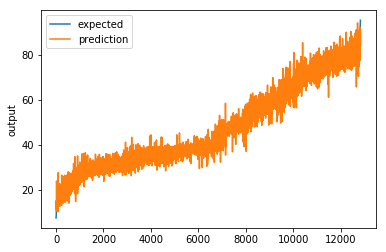

In [30]:
chart_regression(y_pred.flatten(),y_test)

### Applying Facial Filters on test data from predicted facial feature locations.

In [300]:
import skimage.color
from skimage.filters import median
from skimage.io import imread

In [301]:
moustache = plt.imread('mustache-png-1317.png')
moustache = skimage.color.rgb2gray(moustache)

In [302]:
star = imread('stars-png-612.png')
star = skimage.color.rgb2gray(star)

In [303]:
moustache = median(moustache, selem=np.ones((3, 3)))
star = median(star, selem=np.ones((3, 3)))

c:\anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))
c:\anaconda3\lib\site-packages\skimage\util\dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


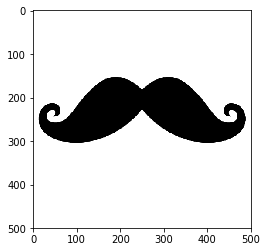

In [304]:
plt.imshow(moustache, cmap='gray')

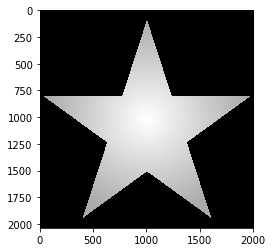

In [305]:
plt.imshow(star, cmap='gray')

In [306]:
from skimage import measure
moustache_contour = measure.find_contours(moustache, 0.8)[0]
moustache_contour -= np.array([250, 250])

In [307]:
star_contour = measure.find_contours(star, 0.8)[0]
star_contour -= np.array([250, 250])

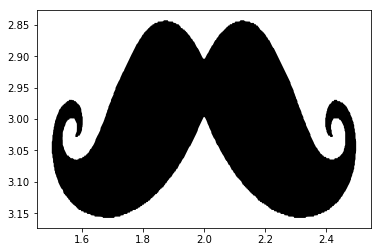

In [309]:
ax = plt.gca()
plot_m(ax, np.array([2, 3]), dx=1)
ax.invert_yaxis()

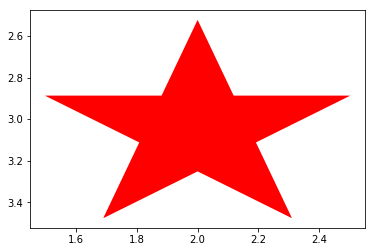

In [310]:
ax = plt.gca()
plot_s(ax, np.array([2, 3]), dx=1)
ax.invert_yaxis()

In [312]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
output_pipe = make_pipeline(
    MinMaxScaler(feature_range=(-1, 1)))

y_train = output_pipe.fit_transform(y_train)

In [ ]:
img = X_test[1, :, :, :][np.newaxis, :, :, :]
predictions = model.predict(img)
xy_predictions = output_pipe.inverse_transform(predictions).reshape(15, 2)

- Placed a star on the left eye of the image using the left eye centre key point
- Placing a moustache on the upper lip using mouth center top lip key point

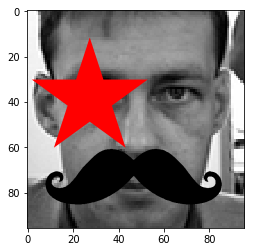

In [314]:
fig, ax = plt.subplots()
ax.imshow(X_test[2, :, :, 0], cmap='gray')
moustache(xy_predictions, ax)
star(xy_predictions, ax)

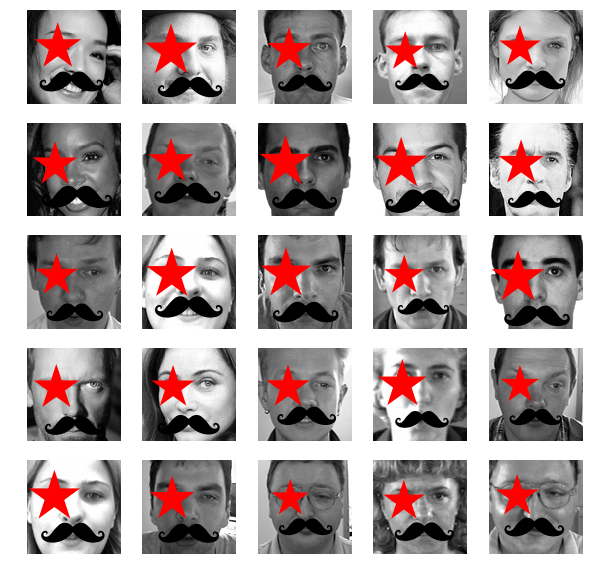

In [316]:
plot_faces_with_filter(model, model_input='2d')